# **Rossmann Store Sales Prediction**

# Abstract

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Here we are predicting 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. In this assignment, we are generating linear, logistic models, multi-colinearity and step-wise regression, Interaction effects and regularizations

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/4594/media/rossmann_banner2.png)

# **Data Exploration and Engineering**

In [1]:
# import necessary libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [78]:
data_path = "."

store = pd.read_csv(data_path+"/store.csv",sep=',',dtype= {'StoreType':str,
                                                          'Assortment':str,
                                                          'PromoInterval':str})

train = pd.read_csv(data_path+"/train.csv",sep= ',', parse_dates=['Date'], dtype= {'StateHoliday': str, 'SchoolHoliday':str} )

**Cleaning Train dataset**

In [4]:
train['Year'] = pd.DatetimeIndex(train['Date']).year
train['Month'] = pd.DatetimeIndex(train['Date']).month

*We have created two new variables naming Year and month using the data column in train dataset*  

*Converting object datatype columns to integer datatype as linear regression requires all the columns to be integers*

In [5]:
def factor_to_integer(df, colname, start_value=0):
    while df[colname].dtype == object:
        myval = start_value # factor starts at "start_value".
        for sval in df[colname].unique():
            df.loc[df[colname] == sval, colname] = myval
            myval += 1
        df[colname] = df[colname].astype(int, copy=False)
    print('levels :', df[colname].unique(), '; data type :', df[colname].dtype)

In [6]:
factor_to_integer(train, 'SchoolHoliday')
factor_to_integer(train, 'StateHoliday')

levels : [0 1] ; data type : int32
levels : [0 1 2 3] ; data type : int32


*Check for number of NaNs for selected columns.*

In [7]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : train[colname].isnull().sum() for colname in train.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Store', 0),
 ('DayOfWeek', 0),
 ('Date', 0),
 ('Sales', 0),
 ('Customers', 0),
 ('Open', 0),
 ('Promo', 0),
 ('StateHoliday', 0),
 ('SchoolHoliday', 0),
 ('Year', 0),
 ('Month', 0)]

In [16]:
train = train.loc[train['StateHoliday']<2]

**Cleaning Store Dataset**

In [17]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : store[colname].isnull().sum() for colname in store.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Promo2SinceWeek', 544),
 ('Promo2SinceYear', 544),
 ('PromoInterval', 544),
 ('CompetitionOpenSinceMonth', 354),
 ('CompetitionOpenSinceYear', 354),
 ('CompetitionDistance', 3),
 ('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('Promo2', 0)]

In [18]:
store['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

*If there is no promotion, then the corresponding columns should have zero values.*

In [19]:
store.loc[store['Promo2'] == 0, ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']] = 0

In [20]:
store.loc[np.where(store['Promo2']!=0)].head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
10,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


In [21]:
store.loc[store['Promo2'] != 0, 'Promo2SinceWeek'] = store['Promo2SinceWeek'].max() - store.loc[store['Promo2'] != 0, 'Promo2SinceWeek']
store.loc[store['Promo2'] != 0, 'Promo2SinceYear'] = store['Promo2SinceYear'].max() - store.loc[store['Promo2'] != 0, 'Promo2SinceYear']

In [22]:
store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [23]:
factor_to_integer(store, 'PromoInterval', start_value=0)

levels : [0 1 2 3] ; data type : int32


In [24]:
factor_to_integer(store, 'StoreType')
factor_to_integer(store, 'Assortment')

levels : [0 1 2 3] ; data type : int32
levels : [0 1 2] ; data type : int32


*Are there still missing values?*

In [25]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : store[colname].isnull().sum() for colname in store.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('CompetitionOpenSinceMonth', 354),
 ('CompetitionOpenSinceYear', 354),
 ('CompetitionDistance', 3),
 ('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('Promo2', 0),
 ('Promo2SinceWeek', 0),
 ('Promo2SinceYear', 0),
 ('PromoInterval', 0)]

*Filling the missing values with sklearn’s built-in command. Filling with the column.median().*

In [26]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer( strategy='median').fit(store)
store_imputed = imp.transform(store)
store2 = pd.DataFrame(store_imputed, columns=store.columns.values)

In [27]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : store2[colname].isnull().sum() for colname in store2.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('CompetitionDistance', 0),
 ('CompetitionOpenSinceMonth', 0),
 ('CompetitionOpenSinceYear', 0),
 ('Promo2', 0),
 ('Promo2SinceWeek', 0),
 ('Promo2SinceYear', 0),
 ('PromoInterval', 0)]

In [28]:
store2['CompetitionOpenSinceMonth'] = store2['CompetitionOpenSinceMonth'].max() - store2['CompetitionOpenSinceMonth']
store2['CompetitionOpenSinceYear'] = store2['CompetitionOpenSinceYear'].max() - store2['CompetitionOpenSinceYear']


In [29]:
store2.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111.0,1.0,0.0,1900.0,6.0,1.0,1.0,19.0,2.0,1.0
1111,1112.0,0.0,1.0,1880.0,8.0,9.0,0.0,0.0,0.0,0.0
1112,1113.0,1.0,1.0,9260.0,4.0,5.0,0.0,0.0,0.0,0.0
1113,1114.0,1.0,1.0,870.0,4.0,5.0,0.0,0.0,0.0,0.0
1114,1115.0,2.0,1.0,5350.0,4.0,5.0,1.0,28.0,3.0,3.0


*Integrating Train and Store datasets*

In [30]:
train_store = pd.merge(train, store2, how = 'left', on='Store')

# Visual Exploration

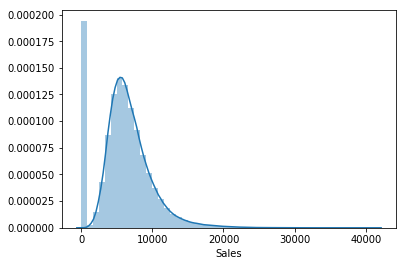

In [80]:
import seaborn as sns
sns.distplot(train_store['Sales']) #Generates a plot graph for Sales values

*Generating boxplots for Sales grouped by Year*

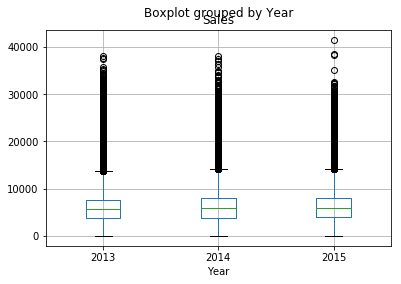

In [32]:
train_store.boxplot(column='Sales', by='Year')
plt.show()

*Generating boxplots for Sales grouped by Month*

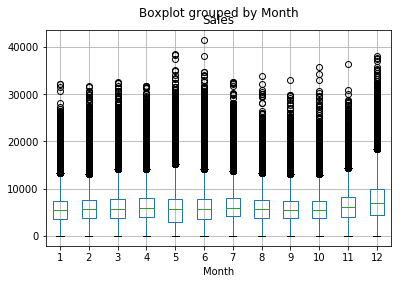

In [33]:
train_store.boxplot(column='Sales', by='Month')
plt.show()

*Generating histogram plots for Sales grouped by Year*

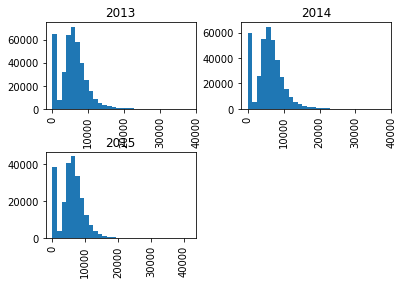

In [87]:
train_store.hist(column='Sales', by='Year', bins=30)
plt.show()

*Generating histogram plots for Sales grouped by Month*

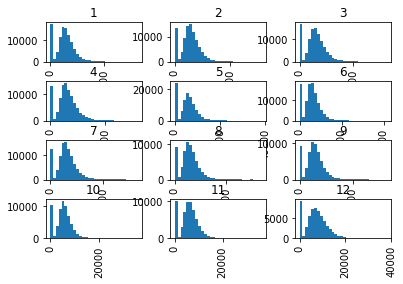

In [35]:
train_store.hist(column='Sales', by='Month', bins=30)
plt.show()

## **Part C: Multi-Colinearity and stepwise regression**

## **Part E: Regularization**

In [71]:
train_model.head(5)

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,1,1,0,0,0,7,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
1,2,5,6064,1,1,0,0,0,7,1.0,0.0,570.0,1.0,8.0,1.0,37.0,5.0,1.0
2,3,5,8314,1,1,0,0,0,7,1.0,0.0,14130.0,0.0,9.0,1.0,36.0,4.0,1.0
3,4,5,13995,1,1,0,0,0,7,0.0,1.0,620.0,3.0,6.0,0.0,0.0,0.0,0.0
4,5,5,4822,1,1,0,0,0,7,1.0,0.0,29910.0,8.0,0.0,0.0,0.0,0.0,0.0


In [72]:
train_model['MeanSalesStore'] = train_model.groupby('Store')['Sales'].transform('mean')

In [73]:
train_model = train_model[train_model['Sales']>0]

In [75]:
train_model['CrossedMeanSales'] = np.where(train_model['Sales'] >= train_model['MeanSalesStore'], 1,0 )

In [77]:
train_model.to_csv('train_model_classification.csv')

In [89]:
train_model.head(5
            )

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,1,1,0,0,0,7,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
1,2,5,6064,1,1,0,0,0,7,1.0,0.0,570.0,1.0,8.0,1.0,37.0,5.0,1.0
2,3,5,8314,1,1,0,0,0,7,1.0,0.0,14130.0,0.0,9.0,1.0,36.0,4.0,1.0
3,4,5,13995,1,1,0,0,0,7,0.0,1.0,620.0,3.0,6.0,0.0,0.0,0.0,0.0
4,5,5,4822,1,1,0,0,0,7,1.0,0.0,29910.0,8.0,0.0,0.0,0.0,0.0,0.0
